In [1]:
#Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

#set_seed and np.random.seed are used to set the random seed for reproductibility purpose

In [2]:
set_seed(455)
np.random.seed(455)

In [3]:
#Load the datset
dataset=pd.read_csv('Mastercard_stock_history.csv',
                   index_col='Date',
                   parse_dates=["Date"]).drop(["Dividends","Stock Splits"], axis=1)
#index_col="Date"---used to set the date which is used the index as resulting parameter.
#parse_date=which is used to the "Date" column will be parsed as a date object
#drop=remove the Dividends and Stock_Split column with axis 1
print(dataset.head())

                               Open      High       Low     Close     Volume
Date                                                                        
2006-05-25 00:00:00-04:00  3.677800  4.202548  3.668674  4.197985  395343000
2006-05-26 00:00:00-04:00  4.225363  4.265517  4.025502  4.100336  103044000
2006-05-30 00:00:00-04:00  4.103990  4.104902  3.910517  4.015467   49898000
2006-05-31 00:00:00-04:00  4.047406  4.139579  4.047406  4.101250   30002000
2006-06-01 00:00:00-04:00  4.100334  4.389630  4.097596  4.335786   62344000


In [4]:
print(dataset.describe())

              Open         High          Low        Close        Volume
count  4733.000000  4733.000000  4733.000000  4733.000000  4.733000e+03
mean    157.218445   158.751430   155.650434   157.248719  1.062101e+07
std     151.827873   153.182400   150.433224   151.846666  1.632991e+07
min       3.677800     4.024589     3.668674     4.006337  6.411000e+05
25%      24.703870    25.007020    24.386382    24.721483  3.020000e+06
50%      87.602214    88.402167    86.976627    87.724739  4.742400e+06
75%     298.458871   302.054722   294.400031   298.368073  1.062100e+07
max     577.330017   582.229980   570.000000   576.309998  3.953430e+08


In [5]:
dataset.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

C:\Users\shail\AppData\Local\Temp\ipykernel_2176\3080265558.py:8: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(f"Train(Before {tend+1})",f"Test({tend+1}and beyond)")


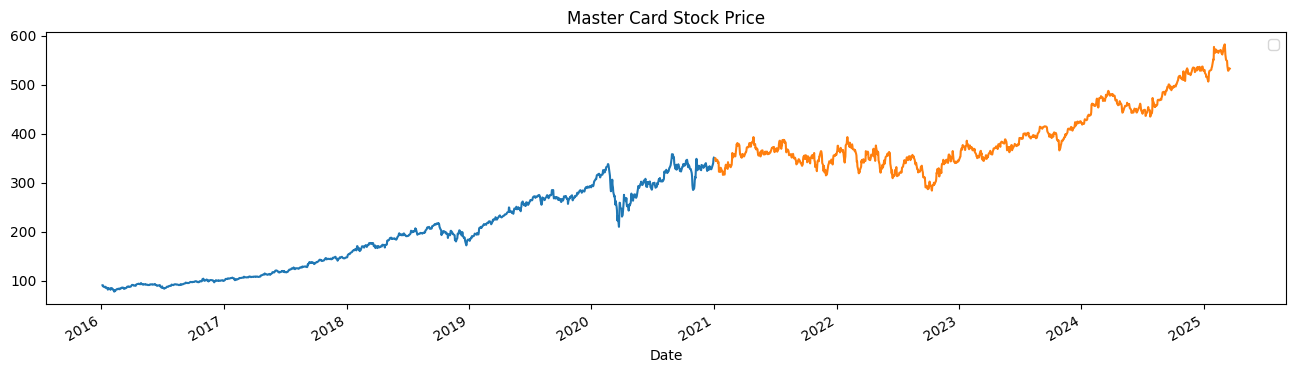

In [6]:
tstart= 2016
tend= 2020
dataset.index = pd.to_datetime(dataset.index, utc=True)

def train_test_split(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}","High"].plot(figsize=(16,4), legend=True)
    dataset.loc[f"{tend+1}":,"High"].plot(figsize=(16,4), legend=True)
    plt.legend(f"Train(Before {tend+1})",f"Test({tend+1}and beyond)")
    plt.title("Master Card Stock Price")
    plt.show()

train_test_split(dataset, tstart, tend)    

In [7]:
#data preprocessing
def train_test_split(dataset, tstart,tend):
    train=dataset.loc[f"{tstart}": f"{tend}","High"].values
    test=dataset.loc[f"{tend+1}":, "High"].values
    return train, test

training_set, test_set= train_test_split(dataset, tstart,tend)

In [8]:
#standardize the dataset
sc=MinMaxScaler(feature_range=(0,1))
training_set=training_set.reshape(-1,1)
training_set_scaled=sc.fit_transform(training_set)

In [13]:
#split the sequences
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

    

In [14]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [15]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 125)                 │          63,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0401
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0031
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0021
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0011
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0011
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 9.1169e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 8.1384e-04
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 7.4984e-04
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 8.3438e-04
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 8.5019e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 8.0229e-04
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 7.5762e-04
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 7.0958e-04
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 7.0583e-04
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━

In [17]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [19]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))


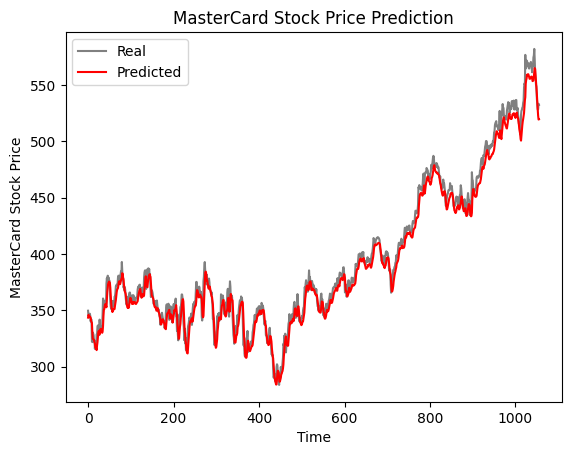

In [20]:
plot_predictions(test_set,predicted_stock_price)

In [21]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 8.50.


In [23]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

C:\python 3.11\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 125)                 │          48,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,126 (187.99 KB)

 Trainable params: 48,126 (187.99 KB)

 Non-trainable params: 0 (0.00 B)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


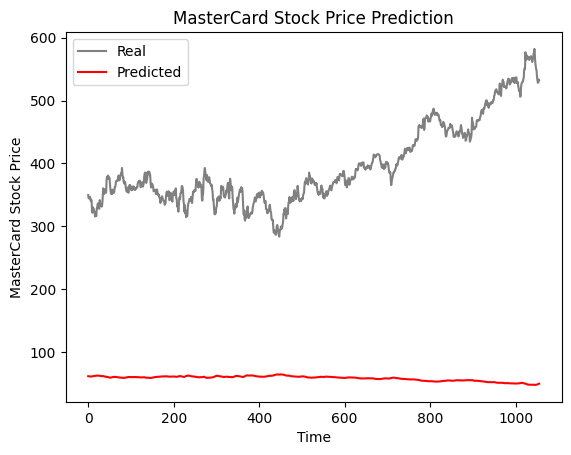

In [24]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

In [25]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 345.42.
